In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import itertools as itt
from ipywidgets import widgets
import ConfigReader as cr

/home/mendozah/workspace/envHDMp/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/mendozah/workspace/envHDMp/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#Styles
sns.set_style('darkgrid')
sns.set_color_codes()
plt.rcParams['figure.figsize'] = (12.0, 9.0)

plt.rc('text', usetex=False)
plt.rc('font', size=20.0, family='serif')

In [3]:
# key -> dataset code, name -> dataset name
dataset_dict = {'1128_bac': 'OVA_Breast', '554_bac':'MNIST', '46_bac':'Splice'}

In [4]:
[dataset_dict.get(k) for k in dataset_dict]

['MNIST', 'OVA_Breast', 'Splice']

In [5]:
reader = cr.ConfigReader()

In [6]:
base_data_dir = '/media/mendozah/My Passport/Master_Arbeit/constrained_DeepNet_Configs/'

In [8]:
solvers = ['adam', 'adadelta', 'adagrad', 'nesterov', 'sgd', 'momentum']
solvers_dirs = list(map(lambda X: X + '_results', solvers))
policies = ['fixed', 'inv', 'exp', 'step']
interesting_params = [ 'response', 'solver', 'learning_rate', 'beta1', 'beta2', 'momentum',
                      'lambda2', 'lr_policy','gamma', 'power', 'epoch_step']

In [ ]:
[i for i in itt.product(solvers_dirs, policies)]

In [ ]:
[ x[1] for x in os.walk(os.path.join(base_data_dir, 'adam_results'))][1]

In [11]:
mean_ds = []
sem_ds = []
params_frame = []
for key in dataset_dict:
    policy_solver_mean = []
    policy_solver_sem = []
    params_list = []
    for j in solvers_dirs:
        mean_list = []
        sem_list = []
        for i in policies:
            data_dir = os.path.join(base_data_dir, j, dataset_dict[key], i)
            _, bdf = reader.load_run_configs(data_dir=data_dir, dataset=key, preprocessor=None)
            params_list.append(bdf.ix[:, interesting_params])
            mean_list.append(bdf.response.mean())
            sem_list.append(bdf.response.sem())
        solver_mean = np.array(mean_list)
        solver_sem = np.array(sem_list)
        policy_solver_mean.append(solver_mean)
        policy_solver_sem.append(solver_sem)
    params_frame.append(pd.concat(params_list,axis=0))
    mean_df = pd.DataFrame(policy_solver_mean, index=solvers, columns=policies)
    sem_df = pd.DataFrame(policy_solver_sem, index=solvers, columns=policies)    
    mean_ds.append(mean_df)
    sem_ds.append(sem_df)
mean_datasets = pd.concat(mean_ds, axis=1, keys=[dataset_dict.get(k) for k in dataset_dict],
                          names = ['datasets', 'policies'])
sem_datasets = pd.concat(sem_ds, axis=1, keys=[dataset_dict.get(k) for k in dataset_dict],
                         names = ['datasets', 'policies'])
params_df = pd.concat(params_frame, axis=0, keys=[dataset_dict.get(k) for k in dataset_dict],
                      names=['dataset'])
params_df.loc[:, 'lr_policy'] = params_df.ix[:,'lr_policy'].fillna('fixed')
params_df = params_df.apply(pd.to_numeric, errors='ignore')

In [12]:
params_df.loc[:, 'lr_policy'] = params_df.ix[:,'lr_policy'].fillna('fixed')
params_df = params_df.apply(pd.to_numeric, errors='ignore')
params_df = params_df.reset_index(level=0)

In [13]:
mean_datasets.applymap(lambda X: "{:.3f}".format(X)) + '±' + sem_datasets.applymap(lambda x: "{:.3f}".format(x))

datasets        MNIST                                          OVA_Breast  \
policies        fixed          inv          exp         step        fixed   
adam      0.021±0.001  0.019±0.001  0.025±0.001  0.022±0.001  0.014±0.001   
adadelta  0.034±0.010  0.056±0.013  0.094±0.015  0.044±0.012  0.019±0.002   
adagrad   0.024±0.001  0.026±0.002  0.032±0.002  0.023±0.001  0.012±0.000   
nesterov  0.027±0.002  0.039±0.003  0.057±0.006  0.044±0.006  0.015±0.002   
sgd       0.036±0.007  0.041±0.002  0.075±0.013  0.040±0.004  0.017±0.002   
momentum  0.028±0.004  0.036±0.003  0.058±0.005  0.042±0.004  0.012±0.000   

datasets                                              Splice               \
policies          inv          exp         step        fixed          inv   
adam      0.015±0.002  0.014±0.001  0.014±0.001  0.062±0.002  0.059±0.003   
adadelta  0.021±0.003  0.014±0.001  0.019±0.002  0.086±0.003  0.095±0.003   
adagrad   0.015±0.002  0.015±0.002  0.015±0.002  0.051±0.002  0.056±0.002   
nesterov  0.012±0.000  0.016±0.002  0.014±0.001  0.073±0.003  0.071±0.002   
sgd       0.016±0.002  0.016±0.003  0.015±0.002  0.086±0.002  0.091±0.002   
momentum  0.014±0.001  0.014±0.001  0.012±0.000  0.069±0.002  0.075±0.002   

datasets                            
policies          exp         step  
adam      0.065±0.003  0.064±0.002  
adadelta  0.094±0.002  0.094±0.002  
adagrad   0.059±0.003  0.057±0.003  
nesterov  0.075±0.003  0.085±0.002  
sgd       0.094±0.002  0.090±0.002  
momentum  0.078±0.002  0.071±0.004

In [14]:
grouped_df = mean_datasets.groupby(level=('policies'), axis=1)
mean_df = grouped_df.mean()
sem_df = sem_datasets.groupby(level=('policies'), axis=1).mean()

In [15]:
mean_df.applymap(lambda X: "{:.4f}".format(X)) + ' ± ' + sem_df.applymap(lambda x: "{:.3f}".format(x))

policies,fixed,inv,exp,step
adam,0.0322 ± 0.002,0.0310 ± 0.002,0.0348 ± 0.002,0.0332 ± 0.001
adadelta,0.0464 ± 0.005,0.0574 ± 0.006,0.0670 ± 0.006,0.0524 ± 0.005
adagrad,0.0291 ± 0.001,0.0323 ± 0.002,0.0352 ± 0.002,0.0316 ± 0.002
nesterov,0.0384 ± 0.002,0.0410 ± 0.002,0.0495 ± 0.003,0.0477 ± 0.003
sgd,0.0463 ± 0.004,0.0493 ± 0.002,0.0617 ± 0.006,0.0485 ± 0.003
momentum,0.0365 ± 0.002,0.0416 ± 0.002,0.0499 ± 0.003,0.0419 ± 0.003


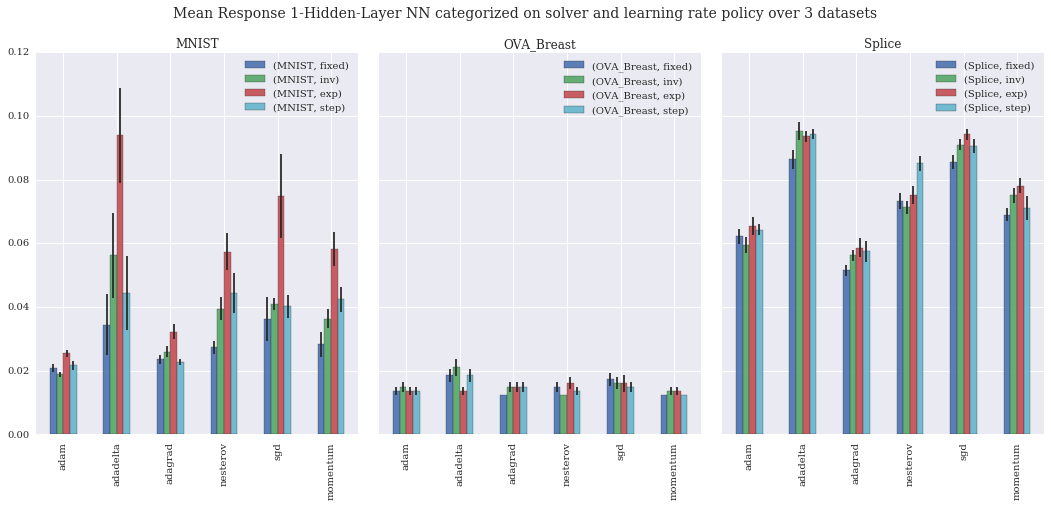

In [16]:
gmean = mean_datasets.groupby(level=('datasets'), axis=1)
gsem = sem_datasets.groupby(level=('datasets'), axis=1)
fig_means, axs = plt.subplots(nrows=1, ncols=3, figsize=(15., 7.), sharey=True)
for ax, (name, groups), (_, group_sem) in zip(axs.flat,gmean, gsem):
    groups.plot(kind='bar',label=name, alpha=0.9, ax=ax, yerr=group_sem)
    ax.set_title(name)
    ax.legend()
fig_means.suptitle('Mean Response 1-Hidden-Layer NN categorized on solver and learning rate policy over 3 datasets',
                   fontsize=14, y=1.02)
# fig_means.savefig(os.path.join('images', 'mean_response_datasets.png'))
plt.tight_layout()

In [ ]:
def bar_policy(policies):
    mean_df[policies].plot(kind='bar', yerr=sem_df[policies])

widgets.interact(bar_policy, policies=policies)

In [23]:
mean_df['fixed']

adam        0.032182
adadelta    0.046447
adagrad     0.029125
nesterov    0.038431
sgd         0.046340
momentum    0.036500
Name: fixed, dtype: float64

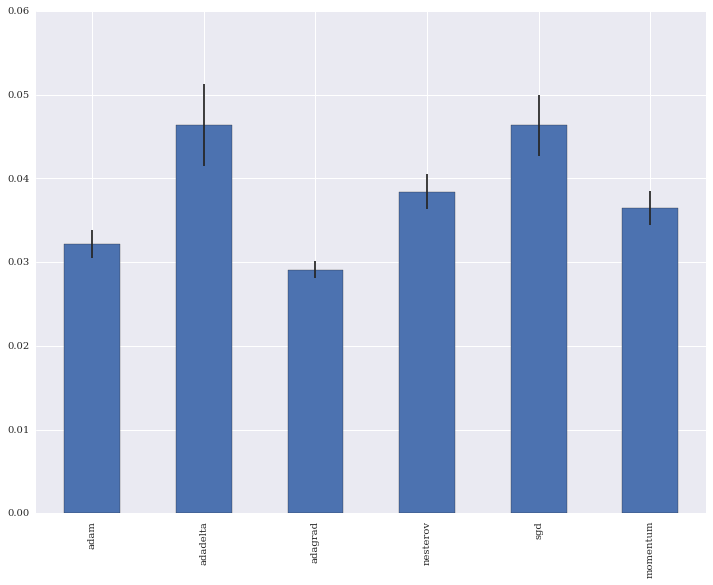

In [19]:
mean_df.plot(kind='bar', yerr=sem_df)

In [61]:
plt.rcdefaults()

In [63]:
sns.set_style('whitegrid', {'axes.linewidth':1.25, 'axes.edgecolor':'0.15',
                            'grid.linewidth':1.5, 'grid.color':'gray'})
sns.set_color_codes()

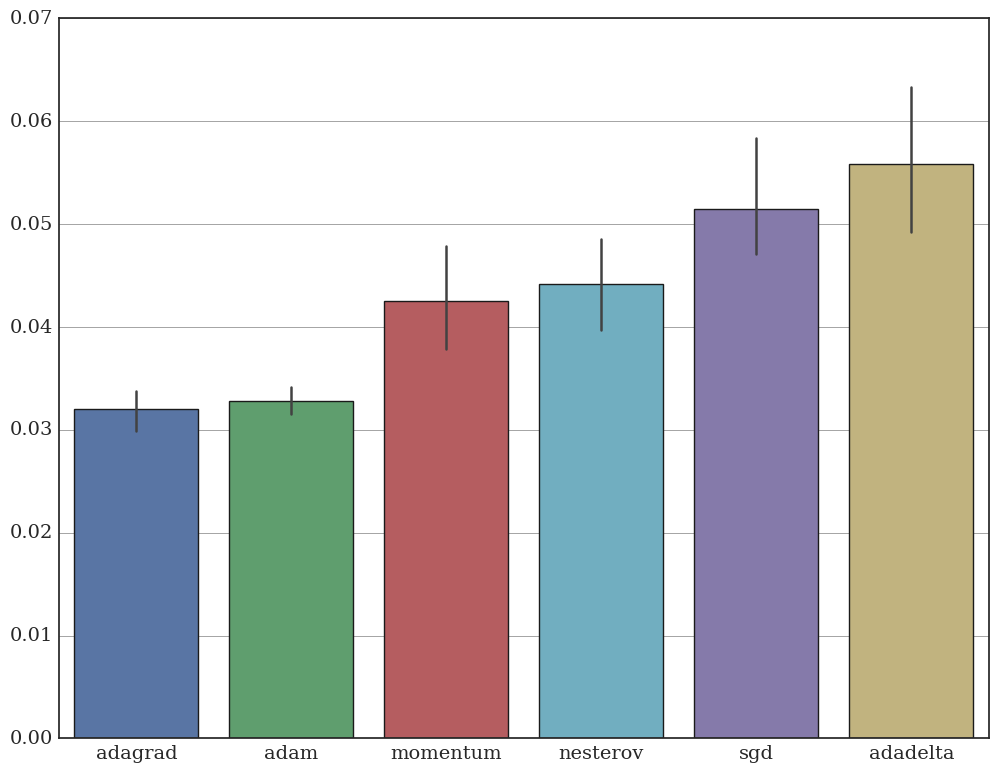

In [102]:
sns.barplot(data=mean_df.sort_values(by=['fixed']).T)

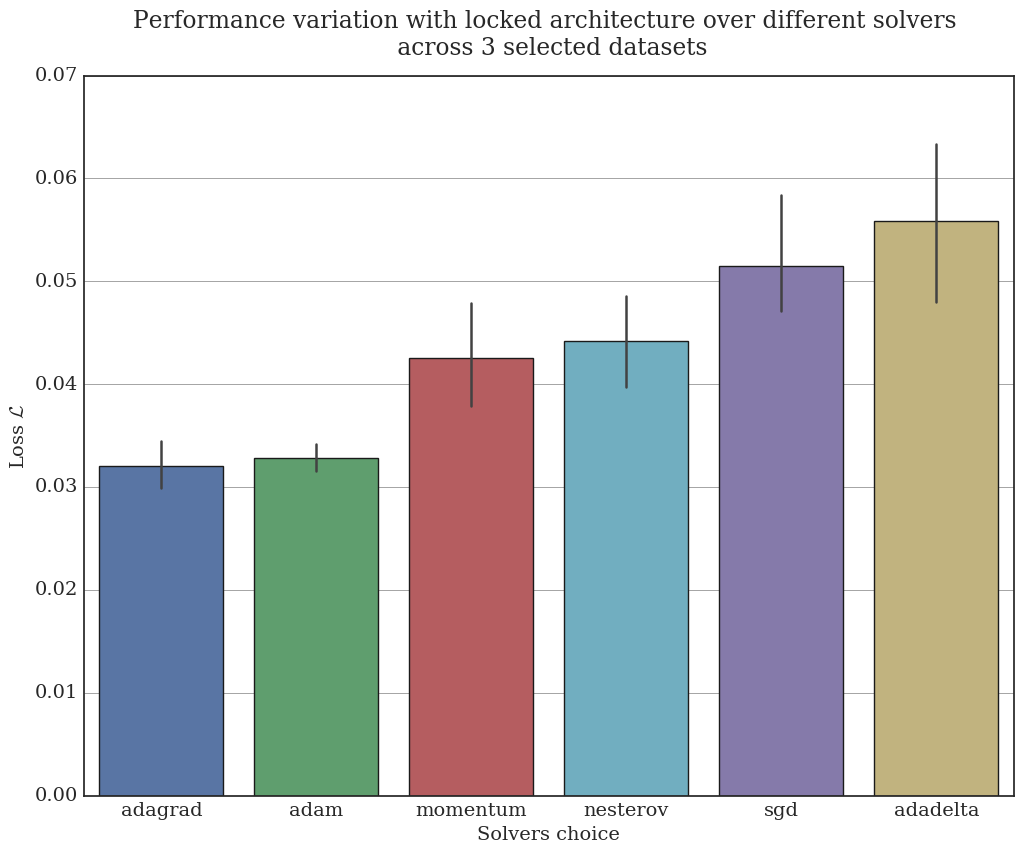

In [131]:
plt.rcParams['figure.figsize'] = (12.0, 9.0)
plt.rc('text', usetex=False)
plt.rc('font', size=14.0, family='serif')
fig_mean, ax_change = plt.subplots(1,1)
ax_change.set_title('Performance variation with locked architecture over different solvers \n across 3 selected datasets', y=1.02)
sns.barplot(data=mean_df.sort_values(by=['fixed'], ascending=True).T, ax=ax_change)
ax_change.set_ylabel('Loss $\mathcal{L}$')
ax_change.set_xlabel('Solvers choice')
#fig_mean.savefig('/home/mendozah/workspace/thesis_autonet/images/solver_variation.pdf')
fig_mean.show()

In [106]:
mean_df.pct_change()

policies,fixed,inv,exp,step
adam,NaN,NaN,NaN,NaN
adadelta,0.443249,0.852638,0.926792,0.580405
adagrad,-0.372950,-0.437513,-0.474652,-0.396283
nesterov,0.319542,0.269961,0.406258,0.507523
sgd,0.205784,0.201694,0.245582,0.016252
momentum,-0.212334,-0.155487,-0.190416,-0.135551


In [126]:
a = mean_df.apply(lambda X: (X.mean()-X)/X.std())

In [ ]:
# Rescale values in log-scale
params_rescale = ['learning_rate','lambda2', 'beta1', 'beta2']
params_df.loc[:,params_rescale]=params_df.ix[:,params_rescale].applymap(lambda x: np.log10(x))

In [ ]:
# Plot the empirical CDF
sorted_Y = (params_df.sort_values(by='response', ascending=True)['response'].values)
yvals = np.arange(len(sorted_Y)) / float(len(sorted_Y))

plt.plot( sorted_Y, yvals )
plt.xlabel("Cross-validation error $y(x)$")
plt.ylabel(r"Number of Configs (%)")
plt.xlim(0.0, 0.1)
plt.title("Empirical CDF of configurations based on validation error")
plt.show()

## After Setting the frames. Start with the plotting

In [ ]:
## TODO: Review how to make filtered and the figure return
def plotting_threshold(error_threshold, categories):
    #global filtered
    filtered = params_df[params_df.response <= error_threshold]
    fig_f, axs = plt.subplots(ncols=2,nrows=1, figsize=(15.0, 8.5))
    ax0, ax1 = axs.flat
    sns.boxplot(x=categories, y='response', data=filtered, ax=ax0)
    sns.countplot(y=categories, data=filtered, ax=ax1)
    fig_f.tight_layout()

In [ ]:
widgets.interact(plotting_threshold, error_threshold=(0.01,0.2,0.01),
                 categories={'Solver':'solver', 'Policy':'lr_policy'})

In [ ]:
# Create the grouping of the filtered DF
solver_filt = params_df.groupby('solver')

In [ ]:
g_barGrid = sns.FacetGrid(data=params_df, col='solver', row='lr_policy', hue='solver',
                              size=3.9, aspect=0.8)
g_barGrid.map(sns.distplot, 'learning_rate', hist=True, kde=False, rug=True, bins=6)
g_barGrid.add_legend()
g_barGrid.fig.suptitle('Distribution of learning rate',
                           fontsize=12, y=1.02)
g_barGrid.fig.subplots_adjust(wspace=.01,)
#g_barGrid.fig.savefig('images_'+  dataset_name + 'distro_lr_solver_vs_policy.png')

In [ ]:
g_kdeGrid = sns.FacetGrid(data=params_df, col='solver', hue='lr_policy',
                          col_wrap=3, size=3.9, aspect=0.8)
g_kdeGrid.map(sns.distplot, 'learning_rate', hist=False, kde=True, rug=True)
g_kdeGrid.add_legend()
g_kdeGrid.fig.suptitle('Distribution of learning rate',
                           fontsize=12, y=1.02)
g_kdeGrid.fig.subplots_adjust(wspace=.01,)
# g_kdeGrid.fig.savefig('images_'+ dataset_name + 'kde_lr_solver.png')

## Density estimation and histograms of parameters based on filters

In [ ]:
# Seaborns Normed Distribution plots
for name,groups in solver_filt:
    sns.distplot(groups.learning_rate.values, bins=6, kde_kws={'label':name})

In [ ]:
#Subplots of the previous histogram
color_histograms = sns.color_palette('Set1_r',12, desat=1.0)
fig1, axs = plt.subplots(nrows=3, ncols=2, sharey='row', sharex=True)
for iterate_axis, (name, groups) in zip(axs.flat, solver_filt):
    sns.distplot(groups.learning_rate.values, bins=6, kde_kws={'label':name},
                 color=color_histograms.pop(), ax=iterate_axis)
    iterate_axis.legend()

In [ ]:
# Create the grouping of the filtered DF
prepro_filt = params_df.groupby('lr_policy')

In [ ]:
def histogram_group_column_plotting(grouping, column):
    #Have to convert the -1 to NaN
    g = params_df.groupby(grouping)
    s = len(g)
    col_hist = sns.color_palette('Paired',s, desat=0.8)
    fig_hist, axs = plt.subplots(nrows=int(np.ceil(s/2.)), ncols=2, sharex='col', sharey='row', figsize=(15., 11.))
    for ax, (name, groups) in zip(axs.flat,g):
        ax.hist(groups[column].dropna().values, bins=15,
                histtype='bar', fill=True, label=name, alpha=0.9, color=col_hist.pop())
        ax.set_xlabel(column + ' values')
        ax.set_ylabel('# of Configs')
        ax.legend()
    fig_hist.suptitle('Distribution of '+ column +' values for each '+(grouping))

In [ ]:
# Create columns dict
Groups = ['solver','lr_policy']
Plott = {'Learning Rate':'learning_rate', 'beta 1':'beta1', 'beta 2':'beta2',
         'Regularization Param':'lambda2', 'gamma':'gamma', 'power':'power', 'step size':'epoch_step'}

In [ ]:
widgets.interact(histogram_group_column_plotting, grouping=Groups, column=Plott)

### Distribution of each parameter over all configurations

In [ ]:
def histogram_column_plotting(column):
    fig_hist = plt.figure(6)
    ax1 = plt.subplot(111)
    ax1.set_title('Histogram of '+column)
    params_df[column].plot(kind='hist', bins=15, ax=ax1)
    ax1.set_xlabel('values')

In [ ]:
widgets.interact(histogram_column_plotting, column=list(params_df.columns.values[1:]))